In [98]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

import cv2
import numpy as np
from matplotlib import pyplot as plt
import albumentations as A
from tifffile import imread
import segmentation_models as sm
from random import randint
from tifffile import imread
import glob

# Import dataset

In [99]:
n_classes = 4

images = []
masks = []

# base_uri = r'C:\Users\USER\Desktop\svs\export\S56-01604_phD_B'
base_uri = r'D:\OneDrive-CMU\Desktop_Dell\QuPath\export\S56-01604_phD_B'

# get images
for file_path in glob.glob(base_uri + '/images' + '/*.tif'):
    image = imread(file_path)
    images.append(image)
    # print(image.shape)

# get masks
for file_path in glob.glob(base_uri + '/masks' + '/*.tif'):

    mask = imread(file_path)
    masks.append(mask)
    # print(image.shape)

images = np.asarray(images)
masks = np.asarray(masks)

n = len(images)

print(images.shape)
print(masks.shape)

(52, 512, 512, 3)
(52, 3, 512, 512)


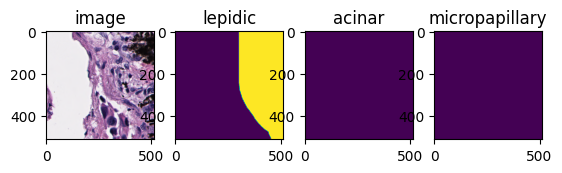

In [112]:
r = randint(0, len(images) - 1)

plt.subplot(1, 4, 1)
plt.title('image')
plt.imshow(images[r])

plt.subplot(1, 4, 2)
plt.title('lepidic')
plt.imshow(masks[r][0])

plt.subplot(1, 4, 3)
plt.title('acinar')
plt.imshow(masks[r][1])

plt.subplot(1, 4, 4)
plt.title('micropapillary')
plt.imshow(masks[r][2])

plt.show()

# print(masks[r][0])

In [114]:
print(np.unique(masks))
print(masks.shape)

[  0 255]
(52, 3, 512, 512)


# Process dataset

##### Convert labels' index

In [115]:
for idx in range(n):
    for c in range(3):
        masks[idx][c][masks[idx][c] == 255] = c + 1

[0 1]


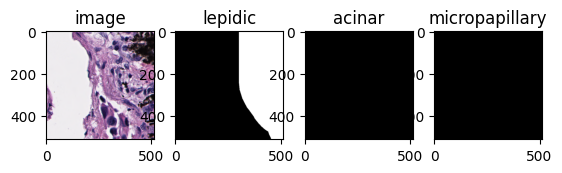

In [120]:
r = randint(0, len(images) - 1)
print(np.unique(masks[r]))

plt.subplot(1, 4, 1)
plt.title('image')
plt.imshow(images[r])

plt.subplot(1, 4, 2)
plt.title('lepidic')
plt.imshow(masks[r][0], cmap='grey')

plt.subplot(1, 4, 3)
plt.title('acinar')
plt.imshow(masks[r][1], cmap='grey')

plt.subplot(1, 4, 4)
plt.title('micropapillary')
plt.imshow(masks[r][2], cmap='grey')

plt.show()


In [121]:
print(images.shape)
print(masks.shape)


(52, 512, 512, 3)
(52, 3, 512, 512)


##### Merge labels to one image

In [122]:
dimension = (masks.shape[-2], masks.shape[-1])
tmp = []
for i in range(len(masks)):
    merged = np.zeros(dimension)
    for j in range(3):
        merged = np.where(merged==0, masks[i][j], merged)
    
    tmp.append(merged)
    # masks[i] = merged 

tmp = np.asarray(tmp).reshape((n, dimension[0], dimension[1], 1))
# r = randint(0, len(masks)-1)
# print(masks[0][0][0])
masks = tmp

In [123]:
masks.shape

(52, 512, 512, 1)

##### Split dataset

In [158]:
from sklearn.model_selection import train_test_split

# split dataset into train, test, and validation
x_train, x_test, y_train, y_test = train_test_split(images, masks, test_size=0.6, random_state=0)
x_train, x_val, y_train, y_val = train_test_split(images, masks, test_size=0.5, random_state=0)


[0. 1.]


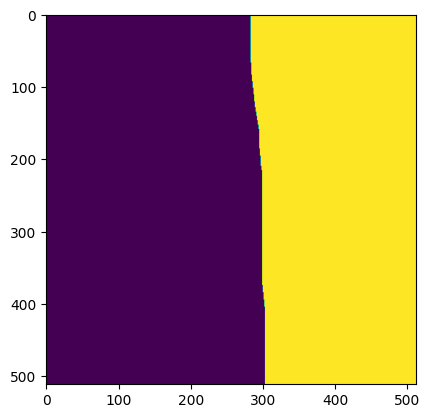

In [139]:
y_train.shape

r = randint(0, len(y_train)-1)
print(np.unique(y_train[r]))
plt.imshow(y_train[r])

In [140]:
from keras.utils import to_categorical

# categorize (format) the labels to 
y_train_cat = to_categorical(y_train, num_classes=n_classes)
y_val_cat = to_categorical(y_val, num_classes=n_classes)
# y_test_cat = to_categorical(y_test, num_classes=n_classes)
# train_cat

# Training

In [141]:
import keras

activation='softmax'
LR = 0.0001
opt = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss (car: 1.; pedestrian: 2.; background: 0.5;)
dice_loss = sm.losses.DiceLoss(class_weights=np.array([0.25, 0.25, 0.25, 0.25])) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 
metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

In [143]:
BACKBONE = 'resnet34'

# define model
model = sm.Unet(BACKBONE, encoder_weights='imagenet', classes=n_classes, activation=activation)

# compile keras model with defined optimizer, loss and metrics
model.compile(opt, total_loss, metrics=metrics)

# model.summary()

In [144]:
# preprocess input
preprocess_input = sm.get_preprocessing(BACKBONE)
pre_x_train = preprocess_input(x_train)
pre_x_val = preprocess_input(x_val)

history = model.fit(pre_x_train, 
          y_train_cat,
          batch_size=8, 
          verbose=2,
          validation_data=(pre_x_val, y_val_cat),
          epochs=5
          )

model.save('test.keras')

Epoch 1/5
4/4 - 134s - 33s/step - f1-score: 0.0308 - iou_score: 0.0159 - loss: 1.0165 - val_f1-score: 2.3035e-04 - val_iou_score: 1.1533e-04 - val_loss: 1.0238
Epoch 2/5
4/4 - 76s - 19s/step - f1-score: 0.0610 - iou_score: 0.0324 - loss: 0.9985 - val_f1-score: 4.7159e-04 - val_iou_score: 2.3616e-04 - val_loss: 1.0255
Epoch 3/5
4/4 - 71s - 18s/step - f1-score: 0.0940 - iou_score: 0.0514 - loss: 0.9911 - val_f1-score: 9.8163e-04 - val_iou_score: 4.9233e-04 - val_loss: 1.0225
Epoch 4/5
4/4 - 72s - 18s/step - f1-score: 0.1620 - iou_score: 0.0937 - loss: 0.9797 - val_f1-score: 6.9060e-04 - val_iou_score: 3.4670e-04 - val_loss: 1.0278
Epoch 5/5
4/4 - 66s - 16s/step - f1-score: 0.2839 - iou_score: 0.1807 - loss: 0.9660 - val_f1-score: 6.0965e-04 - val_iou_score: 3.0592e-04 - val_loss: 1.0319


In [145]:
from keras.models import load_model

model = load_model('./test.keras', compile=False)

In [146]:
pre_x_test = preprocess_input(x_test)
y_pred = model.predict(pre_x_test)
y_pred_argmax = np.argmax(y_pred, axis=3)

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


In [147]:
y_pred_argmax.shape

(32, 512, 512)

In [148]:
from keras.metrics import MeanIoU

IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test[:,:,:,0], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.043633033


In [157]:
y_test[0].shape

(512, 512, 4)

(32, 512, 512, 1)


array([0, 1, 2, 3], dtype=int64)

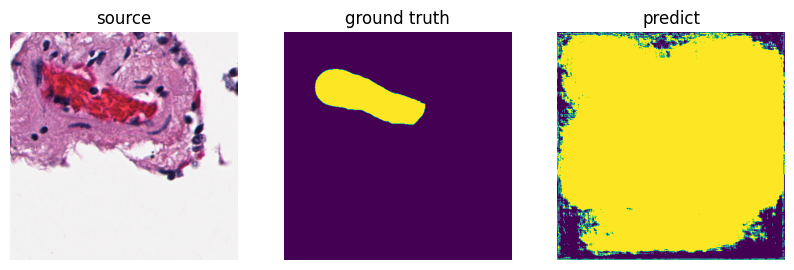

In [173]:
idx = randint(0, len(x_test)-1)

fig, axs = plt.subplots(1, 3, figsize=(10, 5))
print(y_test.shape)

axs[0].imshow(x_test[idx])
axs[0].set_title("source")
axs[0].axis('off')

axs[1].imshow(y_test[idx])
axs[1].set_title("ground truth")
axs[1].axis('off')

axs[2].imshow(y_pred_argmax[idx])
axs[2].set_title("predict")
axs[2].axis('off')

np.unique(y_pred_argmax[idx])